## Importing Libraries

In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import seaborn as sns 
import datetime as dt
from collections import Counter
from nltk.tokenize import sent_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

C:\Users\ROSHAN\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv(r'C:\Users\ROSHAN\Documents\GitHub\extracting-tweets-forecasting-the-upcoming-elections-in-the-us\New Extraction\Data\Biden_No_Retweet_Full_Text.csv',error_bad_lines=False)

In [3]:
df.head()

Date             Tweet_id  Verified  \
0  2020-07-21 23:59:43  1285726179907993601     False   
1  2020-07-21 23:59:27  1285726110513344520     False   
2  2020-07-21 23:59:24  1285726099239055361     False   
3  2020-07-21 23:58:47  1285725945849151490     False   
4  2020-07-21 23:58:02  1285725754961965056     False   

                                               Tweet            User  \
0  @JoeBiden VP Biden I wish you wouldn't debate ...   BballmomEjZay   
1  #GeorgeWill , it’s so sad you wake up everyday...       TalbotMac   
2  Question:\nIf @JoeBiden doesn’t pick a woman o...  bk_middleclass   
3  Right? 🤣🤣🤣 #Biden formally implicated in #Ukra...    MMorganBlair   
4  These idiots let Trump do anything he wants. W...     realfacade1   

          Location               Source  Likes  Followers  Following  Retweets  
0    United States  Twitter for Android      0         54        192         0  
1  East Aurora, NY   Twitter for iPhone      0        882       1554         0  
2    Nashville, TN   Twitter for iPhone      0       1294       1213         0  
3    United States   Twitter for iPhone      1       2476       3334         1  
4       Purgatory   Twitter for Android      0       2764       3799         0

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15098 entries, 0 to 15097
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       15098 non-null  object
 1   Tweet_id   15098 non-null  int64 
 2   Verified   15098 non-null  bool  
 3   Tweet      15098 non-null  object
 4   User       15098 non-null  object
 5   Location   11032 non-null  object
 6   Source     15098 non-null  object
 7   Likes      15098 non-null  int64 
 8   Followers  15098 non-null  int64 
 9   Following  15098 non-null  int64 
 10  Retweets   15098 non-null  int64 
dtypes: bool(1), int64(5), object(5)
memory usage: 1.2+ MB


In [5]:
df.shape

(15098, 11)

# Data Preprocessing & Cleaning

The Date column is an object type. Let us convert it to datetime using datetime module.

In [6]:
df['Date'] = df['Date'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S')) #Convert to date time format

In [7]:
df.dtypes

Date         datetime64[ns]
Tweet_id              int64
Verified               bool
Tweet                object
User                 object
Location             object
Source               object
Likes                 int64
Followers             int64
Following             int64
Retweets              int64
dtype: object

Let us check for any null values in our dataset

In [8]:
df.isnull().sum()

Date            0
Tweet_id        0
Verified        0
Tweet           0
User            0
Location     4066
Source          0
Likes           0
Followers       0
Following       0
Retweets        0
dtype: int64

The location column has upto 4066 values as null. This may be the case since many users didn't voluntarily put it up. However this is not of much concern for our project. Hence we would leave it to null only

In [9]:
df['Source'].value_counts()

Twitter Web App        5910
Twitter for iPhone     4565
Twitter for Android    3267
Twitter for iPad        705
TweetDeck               150
                       ... 
UNIAN.info                1
Traject Social            1
Bitly                     1
An-Nahar Tweeter          1
OTDC                      1
Name: Source, Length: 87, dtype: int64

About 10,000 users tweeted from the web app & from iphone

In [10]:
df['Location'].nunique()

3200

Tweets gathered were from 3200 different locations around the world.

In [11]:
tweets_list = df['Tweet'].tolist()
len(tweets_list)

15098

In [12]:
tweets_list_updated = set(tweets_list)
len(tweets_list_updated)

15046

There seems to be some duplicates in our dataset. Let us remove these using the set function

In [13]:
tweets_list_updated  = list(tweets_list_updated)
type(tweets_list_updated)

list

In [14]:
df['Tweet'].duplicated().sum()

52

In [15]:
df = df.drop_duplicates(subset = 'Tweet', keep = 'first',ignore_index = True)
df.shape

(15046, 11)

Removed all the duplicates using the drop_duplicates function

In [16]:
df['Tweet'].duplicated().sum()

0

### Remove Emojis

In [17]:
def remove_emoji(tweet):
    emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', tweet)



df['Processed_Tweet']=df.Tweet.apply(remove_emoji)


From now on, all the preprocessing & modelling on tweets will be stored in the data column called 'Processed_Tweet'

In [18]:
count = 0
for i in df['Processed_Tweet']:
    if re.match(r'^RT', i):  #remove any rows that contain RT
        df.drop(df.loc[df['Processed_Tweet']==i].index,inplace = True)
        count+=1
    
count

0

The above code is to ensure that there are no retweets in our dataset. Using Regex, this has been confirmed.

In [19]:
df.shape

(15046, 12)

In [20]:
df['Processed_Tweet']

0        @JoeBiden VP Biden I wish you wouldn't debate ...
1        #GeorgeWill , it’s so sad you wake up everyday...
2        Question:\nIf @JoeBiden doesn’t pick a woman o...
3        Right? 🤣🤣🤣 #Biden formally implicated in #Ukra...
4        These idiots let Trump do anything he wants. W...
                               ...                        
15041    Other than going big by eulogizing #StromThurm...
15042    Don't want to leave out the left! Show your su...
15043    Some chatter about #Biden maybe activating res...
15044    Fake #Polls? Why #Biden's 'Nationwide Lead' Ov...
15045    #Joe #Biden #Trump police should not be armed ...
Name: Processed_Tweet, Length: 15046, dtype: object

### Remove Retweets

In [21]:
df['Processed_Tweet'] = [re.sub('^RT[\s]','',i) for i in df['Processed_Tweet']]  #Remove RT substring

In [22]:
df['Processed_Tweet']

0        @JoeBiden VP Biden I wish you wouldn't debate ...
1        #GeorgeWill , it’s so sad you wake up everyday...
2        Question:\nIf @JoeBiden doesn’t pick a woman o...
3        Right? 🤣🤣🤣 #Biden formally implicated in #Ukra...
4        These idiots let Trump do anything he wants. W...
                               ...                        
15041    Other than going big by eulogizing #StromThurm...
15042    Don't want to leave out the left! Show your su...
15043    Some chatter about #Biden maybe activating res...
15044    Fake #Polls? Why #Biden's 'Nationwide Lead' Ov...
15045    #Joe #Biden #Trump police should not be armed ...
Name: Processed_Tweet, Length: 15046, dtype: object

## Remove Usernames

In [23]:
df['Processed_Tweet'] = [re.sub('@[^\s]+', ' ', i) for i in df['Processed_Tweet']] #remove usernames

In [24]:
df['Processed_Tweet']

0          VP Biden I wish you wouldn't debate Trump un...
1        #GeorgeWill , it’s so sad you wake up everyday...
2        Question:\nIf   doesn’t pick a woman of color,...
3        Right? 🤣🤣🤣 #Biden formally implicated in #Ukra...
4        These idiots let Trump do anything he wants. W...
                               ...                        
15041    Other than going big by eulogizing #StromThurm...
15042    Don't want to leave out the left! Show your su...
15043    Some chatter about #Biden maybe activating res...
15044    Fake #Polls? Why #Biden's 'Nationwide Lead' Ov...
15045    #Joe #Biden #Trump police should not be armed ...
Name: Processed_Tweet, Length: 15046, dtype: object

## Remove Any URLs 

In [25]:
df['Processed_Tweet'] = [re.sub('((www\.[^\s]+)|(https?://[^\s]+))', '', i) for i in df['Processed_Tweet']] #Remove urls

In [26]:
df['Processed_Tweet']

0          VP Biden I wish you wouldn't debate Trump un...
1        #GeorgeWill , it’s so sad you wake up everyday...
2        Question:\nIf   doesn’t pick a woman of color,...
3        Right? 🤣🤣🤣 #Biden formally implicated in #Ukra...
4        These idiots let Trump do anything he wants. W...
                               ...                        
15041    Other than going big by eulogizing #StromThurm...
15042    Don't want to leave out the left! Show your su...
15043    Some chatter about #Biden maybe activating res...
15044    Fake #Polls? Why #Biden's 'Nationwide Lead' Ov...
15045    #Joe #Biden #Trump police should not be armed ...
Name: Processed_Tweet, Length: 15046, dtype: object

## Removing Hashtags & Keeping The Word

In [27]:
df['Processed_Tweet'] = [re.sub(r'#([^\s]+)', r'\1', i) for i in df['Processed_Tweet']] # remove the # in #hashtag

In [28]:
df['Processed_Tweet']

0          VP Biden I wish you wouldn't debate Trump un...
1        GeorgeWill , it’s so sad you wake up everyday ...
2        Question:\nIf   doesn’t pick a woman of color,...
3        Right? 🤣🤣🤣 Biden formally implicated in Ukrain...
4        These idiots let Trump do anything he wants. W...
                               ...                        
15041    Other than going big by eulogizing StromThurmo...
15042    Don't want to leave out the left! Show your su...
15043    Some chatter about Biden maybe activating reso...
15044    Fake Polls? Why Biden's 'Nationwide Lead' Over...
15045    Joe Biden Trump police should not be armed to ...
Name: Processed_Tweet, Length: 15046, dtype: object

In [29]:
import preprocessor as p #Module for faster preprocessing specifically for tweets

In [30]:
df['Processed_Tweet'] = [p.clean(i) for i in df['Processed_Tweet']]

In [31]:
df['Processed_Tweet']

0        VP Biden I wish you wouldn't debate Trump unle...
1        GeorgeWill , its so sad you wake up everyday f...
2        Question:If doesnt pick a woman of color, woul...
3        Right? Biden formally implicated in Ukraine sc...
4        These idiots let Trump do anything he wants. W...
                               ...                        
15041    Other than going big by eulogizing StromThurmo...
15042    Don't want to leave out the left! Show your su...
15043    Some chatter about Biden maybe activating reso...
15044    Fake Polls? Why Biden's 'Nationwide Lead' Over...
15045    Joe Biden Trump police should not be armed to ...
Name: Processed_Tweet, Length: 15046, dtype: object

## Removing Any Special Characters, Numbers, Punctuations etc.

In [32]:
#removing unnecessary special characters, numbers, punctuations in tweets
df.Processed_Tweet = df.Processed_Tweet.str.replace("[^a-zA-Z]", " ")


In [33]:
df["Processed_Tweet"]

0        VP Biden I wish you wouldn t debate Trump unle...
1        GeorgeWill   its so sad you wake up everyday f...
2        Question If doesnt pick a woman of color  woul...
3        Right  Biden formally implicated in Ukraine sc...
4        These idiots let Trump do anything he wants  W...
                               ...                        
15041    Other than going big by eulogizing StromThurmo...
15042    Don t want to leave out the left  Show your su...
15043    Some chatter about Biden maybe activating reso...
15044    Fake Polls  Why Biden s  Nationwide Lead  Over...
15045    Joe Biden Trump police should not be armed to ...
Name: Processed_Tweet, Length: 15046, dtype: object

In [34]:
df.Processed_Tweet = [low.lower() for low in df.Processed_Tweet] #Converting into lower case 

In [35]:
df["Processed_Tweet"]

0        vp biden i wish you wouldn t debate trump unle...
1        georgewill   its so sad you wake up everyday f...
2        question if doesnt pick a woman of color  woul...
3        right  biden formally implicated in ukraine sc...
4        these idiots let trump do anything he wants  w...
                               ...                        
15041    other than going big by eulogizing stromthurmo...
15042    don t want to leave out the left  show your su...
15043    some chatter about biden maybe activating reso...
15044    fake polls  why biden s  nationwide lead  over...
15045    joe biden trump police should not be armed to ...
Name: Processed_Tweet, Length: 15046, dtype: object

In [36]:
df['Processed_Tweet'][12] #Sample tweet

'biden took know questions so he could tell you know lies  of course the lies would make absolutely no sense because he has no idea where he is or what hes doing  incontinent twit '

# EDA

In [37]:
df['User'].value_counts()

Hotpage_News       544
jacketrose86       174
mobygrapefan        71
defeatthedevil      67
deepen915           61
                  ... 
RBerlinghof          1
beagle16             1
HelenFogarassy       1
TimFadgen            1
thedeadlydonald      1
Name: User, Length: 8270, dtype: int64

A whopping 544 tweets from Hotpage_News. This seems to be an account owned by an organization. Let us have a look at jacketrose86.

In [38]:
df.query('User == "jacketrose86"').Processed_Tweet.tolist()

['the can be no order when the laws remain unjust  trump s tyranny runs rampant while we die by the thousands   vote joe   liar  liar pants on fire  you re on the wrong side i d history  fk donniedollhands cheetomcasshat biden    landslide istandwithfauci fauciisahero biden',
 'it is our duty to protect the world from trump  we can t let him win another term  donniedollhands cheetomcasshat biden    landslide tangerinetyrant istandwithfauci fauciisahero biden trumpislosing trumpfailedamerica',
 'there are more reasons to not vote for him  staying alive is one of them  biden cares if we live or die   fk donniedollhands cheetomcasshat biden    landslide tangerinetyrant istandwithfauci fauciisahero biden trumpislosing trumpfailedamerica',
 'aww thanks for adding me fk donniedollhands cheetomcasshat biden    landslide tangerinetyrant istandwithfauci fauciisahero biden trumpislosing trumpfailedamerica',
 'thanks so much   have some snacks for cocktail hour  they re about the same size as his

A manual inspection clearly indicates a negative sentiment towards the candidature of Joe Biden

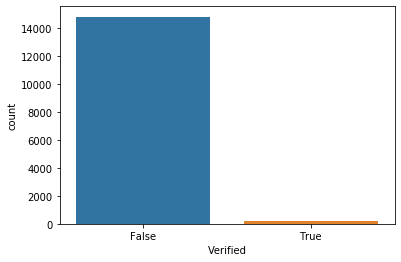

In [39]:
bar = sns.countplot(df['Verified'])

In [40]:
df['Verified'].value_counts()

False    14830
True       216
Name: Verified, dtype: int64

Only 216 verified accounts were extracted. This shouldn't be a problem while calculating our sentiment.

In [41]:
df_verified = df.query('Verified == True')
df_verified 

Date             Tweet_id  Verified  \
116   2020-07-21 23:00:01  1285711153465683971      True   
186   2020-07-21 22:21:56  1285701570932477952      True   
205   2020-07-21 22:14:26  1285699685982838786      True   
228   2020-07-21 22:05:17  1285697381275709441      True   
316   2020-07-21 21:15:04  1285684742617206784      True   
...                   ...                  ...       ...   
14801 2020-07-13 14:58:33  1282690889668755458      True   
14913 2020-07-13 13:26:50  1282667808279670785      True   
15005 2020-07-13 11:52:52  1282644156859518976      True   
15031 2020-07-13 11:25:41  1282637319783284736      True   
15034 2020-07-13 11:20:27  1282636000183881730      True   

                                                   Tweet            User  \
116    Judicial Watch announced it received records f...   JudicialWatch   
186    Stay tuned folks. \n\n#Trump #KAG #KAG2020 🇺🇸🐘...  IamJohnBurnett   
205    Can #Trump overcome #Biden's lead in the polls...  IamJohnBurnett   
228    Support #arts ! Open edition or limited editio...     annawilding   
316    Comment: 'Though #Biden talks about 'ending en...     The_NewArab   
...                                                  ...             ...   
14801  The latest #FoxNews Poll shows Joe #Biden with...        Varneyco   
14913  Arctic at +100℉, record ice melts, devastating...      DemsAbroad   
15005  @realDonaldTrump Yes, it is. Because @JoeBiden...      AndyOstroy   
15031  Hey @realDonaldTrump...resign while you can be...      AndyOstroy   
15034  He still tweets that #COVID19’s a hoax and has...      AndyOstroy   

             Location              Source  Likes  Followers  Following  \
116    Washington, DC           TweetDeck    552    1738234       1924   
186      New York, NY     Twitter Web App      3      15341       3102   
205      New York, NY     Twitter Web App      5      15341       3102   
228     United States     Twitter Web App      2       1706       2015   
316            London      Hootsuite Inc.      2      88631        228   
...               ...                 ...    ...        ...        ...   
14801        New York     Twitter Web App    109     658176        729   
14913      Worldwide!  Twitter for iPhone      3      18747       8730   
15005             NYC  Twitter for iPhone    421      78928       3202   
15031             NYC  Twitter for iPhone    123      78928       3202   
15034             NYC  Twitter for iPhone    329      78928       3202   

       Retweets                                    Processed_Tweet  
116         327  judicial watch announced it received records f...  
186           1  stay tuned folks  trump kag kag     democrats ...  
205           1  can trump overcome biden s lead in the polls  ...  
228           0  support arts   open edition or limited edition...  
316           1  comment   though biden talks about  ending end...  
...         ...                                                ...  
14801        41  the latest foxnews poll shows joe biden with a...  
14913         0  arctic at       record ice melts  devastating ...  
15005        46  yes  it is  because is not an ignorant  incomp...  
15031        37  hey while you can before youre dealt the bigge...  
15034       110  he still tweets that covid  s a hoax and has y...  

[216 rows x 12 columns]

In [42]:
df_verified['User'].value_counts()

AndyOstroy         15
JudicialWatch       9
Varneyco            7
The_NewArab         7
DemsAbroad          7
                   ..
matisaksk           1
SteveAHorn          1
JonChevreau         1
PredictIt           1
EllieGeranmayeh     1
Name: User, Length: 121, dtype: int64

A user by the name AndyOstroy has 15 tweets about Joe Biden in the time-period of extraction. Let us look at some of his tweets.

In [43]:
df_verified.query('User == "AndyOstroy"').Processed_Tweet.tolist()

['its intellectually dishonest  and quite hypocritical  for liberals who preach unity and bipartisanship to be losing their damn minds because one republican is gonna speak at the democratic convention    johnkasich kasich biden',
 'we are now at a new cray cray low in the trump presidency where he s challenged biden to a duel to see who can  ace  the  is this a lion or a monkey   cognitive test    chriswallace',
 'humiliating   historic    landslide  its coming     trump election     biden',
 'hey like how you cried daddy  daddy  please dont let them make me go to vietnam  before he bought you those deferments  coward    trump chriswallace biden',
 'how do you feel about susanrice as biden s vp ',
 'i believe on nov rd were going to witness the biggest  most humiliating  most historic backlash against and republicans this country has ever seen and could ever have imagined    election     biden trump',
 'hey moron   all of this darkness  despair  dysfunction  disease  death you re show

He seems to be very angry towards Joe Biden & clearly has no positive sentiment 

Let us look at another, JudicialWatch

In [44]:
df_verified.query('User == "JudicialWatch"').Processed_Tweet.tolist()

['judicial watch announced it received records from the u s  secret service showing that  for the and a half years of the obama administration  hunter biden traveled extensively while receiving a secret service protective detail  read ',
 '  president  theres no lawful reason for the university of delaware to withhold biden records  read more at',
 ' judicial watch investigators uncovered records from the u s  secret service showing that  for the first and a half years of the obama admin  hunter biden traveled extensively with a secret service protective detail  in newsmax  read ',
 'judicial watch announced it received records from the u s  secret service showing that  for the and a half years of the obama administration  hunter biden traveled extensively while receiving a secret service protective detail  read ',
 'judicial watch announced it received records from the u s  secret service showing that  for the and a half years of the obama administration  hunter biden traveled extensi

On manual inspection, there seems to be sentiment towards Joe Biden. Can be classified as a Neutral user.

Let us observe the dates & how they fair out. Let us observe how many tweets were extracted on which date

In [45]:
days = df['Date'].dt.day.tolist()

In [46]:
no_of_days = Counter(days)
no_of_days

Counter({21: 2084,
         20: 1862,
         19: 1712,
         18: 1322,
         17: 1573,
         16: 1638,
         15: 2020,
         14: 1884,
         13: 951})

Text(0.5, 1.0, 'Count Of Extracted Tweets On Each Day')

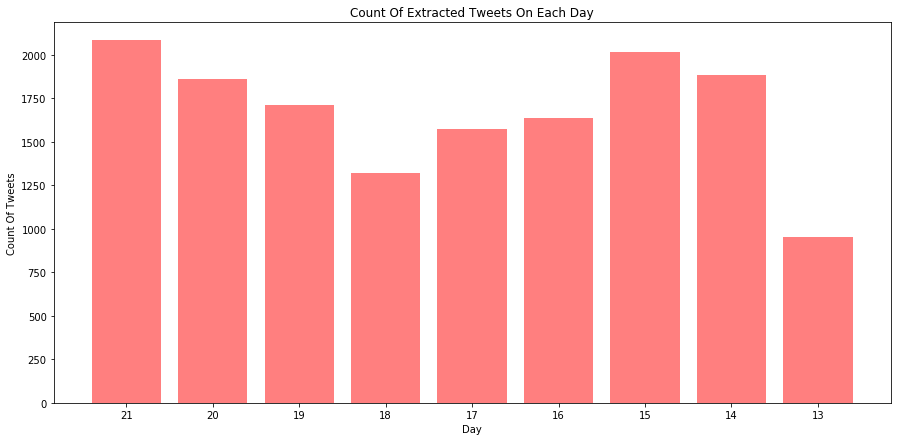

In [47]:
fig = plt.figure(figsize = (15,7))
plt.bar(range(len(no_of_days)), list(no_of_days.values()), align='center', alpha = 0.5,color = 'red')
plt.xticks(range(len(no_of_days)), list(no_of_days.keys()))
plt.xlabel("Day")
plt.ylabel("Count Of Tweets")
plt.title("Count Of Extracted Tweets On Each Day")

We had a maximum of approx 2000 tweets extracted on the 21st July & the 15th of July.

Let us also look at the times (hours) at which the most tweets were extracted.

In [48]:
hours = df['Date'].dt.hour.tolist()

In [49]:
no_of_hours = Counter(hours)
no_of_hours

Counter({23: 857,
         22: 917,
         21: 891,
         20: 829,
         19: 828,
         18: 1107,
         17: 938,
         16: 953,
         15: 867,
         14: 834,
         13: 740,
         12: 560,
         11: 423,
         10: 260,
         9: 156,
         8: 157,
         7: 198,
         6: 237,
         5: 290,
         4: 397,
         3: 475,
         2: 628,
         1: 780,
         0: 724})

Text(0.5, 1.0, 'Count Of Extracted Tweets On Each Hour')

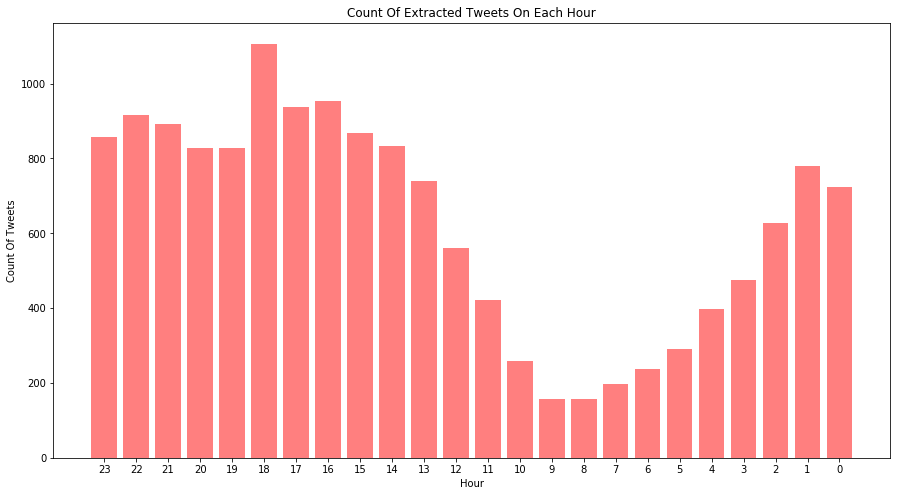

In [50]:
fig = plt.figure(figsize = (15,8))
plt.bar(range(len(no_of_hours)), list(no_of_hours.values()), align='center', alpha = 0.5,color = 'red')
plt.xticks(range(len(no_of_hours)), list(no_of_hours.keys()))
plt.xlabel("Hour")
plt.ylabel("Count Of Tweets")
plt.title("Count Of Extracted Tweets On Each Hour")

Lots of tweets at the 18:00 - 19:00 hour period followed by 16:00 - 17:00 hour

In [51]:
from wordcloud import WordCloud
tokenizer = TweetTokenizer()


We still have to remove stopwords, perform lemmatization & do stemming. So let us proceed with that

### Removing Stop Words

In [52]:
stop_words = set(stopwords.words('english')) 
stop_words = list(stop_words)
print(stop_words)

['this', 'too', 'shouldn', 'for', 'when', 'once', 'off', 'theirs', 'ma', 'same', "hasn't", "you'll", 'if', 'my', 'during', 'below', 'out', 'o', 'it', "mustn't", 'few', 'your', 'on', 'as', 'own', 'y', "wasn't", 'each', "you've", 'at', 'needn', 'yourselves', 'now', "didn't", 'any', 'had', 'don', "don't", 'such', 'him', 'where', 'and', 's', 'be', 'whom', 'under', 'both', 'the', "isn't", 'we', 'do', 'than', 'a', 'these', 'not', 'up', 'm', 'won', 'over', 'between', 'until', 'he', 'just', 'doesn', 'were', 'is', 'against', 'aren', 'have', 'you', 'being', 'an', 'itself', "wouldn't", 've', 'because', 'doing', 'more', "aren't", 'through', 'd', 'further', "you'd", 'while', "you're", 'haven', 'with', 'ain', 'who', 'there', 'has', 'but', 'why', 'above', 'all', 'themselves', 'only', "haven't", 'mightn', 'before', 'its', 'here', 'her', 'our', 'which', "won't", "that'll", 'no', 'hasn', 'herself', 'down', 'yours', 'myself', 'them', "needn't", 'how', 'then', 'isn', 'weren', 'that', 'about', 'having', 's

In [53]:
df['Processed_Tweet'] = df.Processed_Tweet.apply(lambda x: ' '.join(w for w in x.split() if w not in stop_words))   #Remove stopwords

In [54]:
df['Processed_Tweet']

0        vp biden wish debate trump unless debate trump...
1        georgewill sad wake everyday forgetting george...
2        question doesnt pick woman color would black c...
3        right biden formally implicated ukraine scanda...
4        idiots let trump anything wants biden gets ele...
                               ...                        
15041    going big eulogizing stromthurmond look right ...
15042    want leave left show support election hearts f...
15043    chatter biden maybe activating resources fight...
15044    fake polls biden nationwide lead trump says no...
15045                   joe biden trump police armed teeth
Name: Processed_Tweet, Length: 15046, dtype: object

## Tokenizing

In [55]:
df['Processed_Tweet'] = df['Processed_Tweet'].apply(lambda x: tokenizer.tokenize(x))

In [56]:
df['Processed_Tweet']

0        [vp, biden, wish, debate, trump, unless, debat...
1        [georgewill, sad, wake, everyday, forgetting, ...
2        [question, doesnt, pick, woman, color, would, ...
3        [right, biden, formally, implicated, ukraine, ...
4        [idiots, let, trump, anything, wants, biden, g...
                               ...                        
15041    [going, big, eulogizing, stromthurmond, look, ...
15042    [want, leave, left, show, support, election, h...
15043    [chatter, biden, maybe, activating, resources,...
15044    [fake, polls, biden, nationwide, lead, trump, ...
15045            [joe, biden, trump, police, armed, teeth]
Name: Processed_Tweet, Length: 15046, dtype: object

## Stemming & Lemmatization

In [57]:
#Perform stemming & lemmatization
def lemmatize_stemming(text):
    stemmer=PorterStemmer()
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

In [58]:
df['Processed_Tweet'] = df['Processed_Tweet'].apply(lambda x: [lemmatize_stemming(i) for i in x]) # stemming

In [59]:
df['Processed_Tweet']

0        [vp, biden, wish, debat, trump, unless, debat,...
1        [georgewil, sad, wake, everyday, forget, georg...
2        [question, doesnt, pick, woman, color, would, ...
3        [right, biden, formal, implic, ukrain, scandal...
4        [idiot, let, trump, anyth, want, biden, get, e...
                               ...                        
15041    [go, big, eulog, stromthurmond, look, right, l...
15042    [want, leav, leav, show, support, elect, heart...
15043    [chatter, biden, mayb, activ, resourc, fight, ...
15044    [fake, poll, biden, nationwid, lead, trump, sa...
15045               [joe, biden, trump, polic, arm, teeth]
Name: Processed_Tweet, Length: 15046, dtype: object

In [60]:
df['Processed_Tweet'] = df.Processed_Tweet.apply(lambda x: [i for i in x if len(i)>2])

In [61]:
df

Date             Tweet_id  Verified  \
0     2020-07-21 23:59:43  1285726179907993601     False   
1     2020-07-21 23:59:27  1285726110513344520     False   
2     2020-07-21 23:59:24  1285726099239055361     False   
3     2020-07-21 23:58:47  1285725945849151490     False   
4     2020-07-21 23:58:02  1285725754961965056     False   
...                   ...                  ...       ...   
15041 2020-07-13 10:57:58  1282630342038499329     False   
15042 2020-07-13 10:56:26  1282629958205145091     False   
15043 2020-07-13 10:53:50  1282629302199164928     False   
15044 2020-07-13 10:53:46  1282629284524433409     False   
15045 2020-07-13 10:45:12  1282627129172271104     False   

                                                   Tweet             User  \
0      @JoeBiden VP Biden I wish you wouldn't debate ...    BballmomEjZay   
1      #GeorgeWill , it’s so sad you wake up everyday...        TalbotMac   
2      Question:\nIf @JoeBiden doesn’t pick a woman o...   bk_middleclass   
3      Right? 🤣🤣🤣 #Biden formally implicated in #Ukra...     MMorganBlair   
4      These idiots let Trump do anything he wants. W...      realfacade1   
...                                                  ...              ...   
15041  Other than going big by eulogizing #StromThurm...  robertson_alton   
15042  Don't want to leave out the left! Show your su...    GraphicMedia4   
15043  Some chatter about #Biden maybe activating res...     copiousjawnt   
15044  Fake #Polls? Why #Biden's 'Nationwide Lead' Ov...        blinova14   
15045  #Joe #Biden #Trump police should not be armed ...      try4freedom   

                           Location               Source  Likes  Followers  \
0                     United States  Twitter for Android      0         54   
1                   East Aurora, NY   Twitter for iPhone      0        882   
2                     Nashville, TN   Twitter for iPhone      0       1294   
3                     United States   Twitter for iPhone      1       2476   
4                        Purgatory   Twitter for Android      0       2764   
...                             ...                  ...    ...        ...   
15041  Fort Worth, or thereabouts.       Twitter Web App      0       1004   
15042                           NaN      Twitter Web App      0          1   
15043             Lehigh Valley, PA  Twitter for Android      0         84   
15044                           NaN      Twitter Web App      4        836   
15045                 Brookline, MA       Smart Post App      1        125   

       Following  Retweets                                    Processed_Tweet  
0            192         0  [biden, wish, debat, trump, unless, debat, tru...  
1           1554         0  [georgewil, sad, wake, everyday, forget, georg...  
2           1213         0  [question, doesnt, pick, woman, color, would, ...  
3           3334         1  [right, biden, formal, implic, ukrain, scandal...  
4           3799         0  [idiot, let, trump, anyth, want, biden, get, e...  
...          ...       ...                                                ...  
15041       4999         0  [big, eulog, stromthurmond, look, right, look,...  
15042          0         0  [want, leav, leav, show, support, elect, heart...  
15043        210         0  [chatter, biden, mayb, activ, resourc, fight, ...  
15044        432         0  [fake, poll, biden, nationwid, lead, trump, sa...  
15045        612         0             [joe, biden, trump, polic, arm, teeth]  

[15046 rows x 12 columns]

Creating strings for each tweet for putting in the model

In [62]:
texts = []
texts = df.Processed_Tweet.apply(lambda x: [i for i in x] )

In [63]:
all_words = []
for i in texts:
    all_words.append(" ".join(i))
    
all_words

['biden wish debat trump unless debat trump show taxesdeb tell putin stop kill soldiersdeb put sanction putin elect hack amp wish publicli challeng biden rice',
 'georgewil sad wake everyday forget georg elitist like swamper badli need disinfect your new breed senileelit man plan vote biden',
 'question doesnt pick woman color would black commun hold resist biden bidenrepublican',
 'right biden formal implic ukrain scandal report afternoon burisma',
 'idiot let trump anyth want biden get elect want hear word hope biden barack come like',
 'could biden ohio pennsylvania dont buy anyon electiontwitt buy',
 'never teach religion public school want watch biden pander islamdisgust peopl dumb christian countri peopl believ god outnumb non christian religion combin usabiden',
 'dream vote biden biden sweep hous senat presid biden novemb',
 'joy one woman mission expos none good fit potu happi put space time biden blacklivesmatt biden landslid',
 'sleep better obama biden joe biden make americ

In [64]:
text = []
for i in texts:
    for j in i:
        text.append(j)

In [65]:
len(text)

229218

In [66]:
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(' '.join(text))

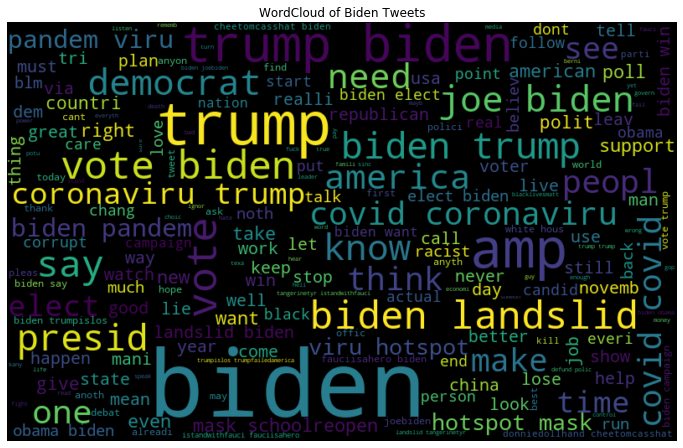

In [67]:
plt.figure(figsize = (12, 12), facecolor="None") 
plt.imshow(wordcloud,interpolation='bilinear') 
plt.axis("off") 
plt.title("WordCloud of Biden Tweets")
plt.show()

## Sentiment Analysis

In [68]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Defining the vectorizer 
vect = TfidfVectorizer(ngram_range=(1,1), max_features=100).fit(text)

# Transform the vectorizer
X_txt = vect.transform(text)

# Transforming to a data frame 
X=pd.DataFrame(X_txt.toarray(), columns=vect.get_feature_names())
X.head(10)

america  american  amp  back  believ  better  biden  black  call  campaign  \
0      0.0       0.0  0.0   0.0     0.0     0.0    1.0    0.0   0.0       0.0   
1      0.0       0.0  0.0   0.0     0.0     0.0    0.0    0.0   0.0       0.0   
2      0.0       0.0  0.0   0.0     0.0     0.0    0.0    0.0   0.0       0.0   
3      0.0       0.0  0.0   0.0     0.0     0.0    0.0    0.0   0.0       0.0   
4      0.0       0.0  0.0   0.0     0.0     0.0    0.0    0.0   0.0       0.0   
5      0.0       0.0  0.0   0.0     0.0     0.0    0.0    0.0   0.0       0.0   
6      0.0       0.0  0.0   0.0     0.0     0.0    0.0    0.0   0.0       0.0   
7      0.0       0.0  0.0   0.0     0.0     0.0    0.0    0.0   0.0       0.0   
8      0.0       0.0  0.0   0.0     0.0     0.0    0.0    0.0   0.0       0.0   
9      0.0       0.0  0.0   0.0     0.0     0.0    0.0    0.0   0.0       0.0   

   ...  voter  want  watch  way  white  win  work  world  would  year  
0  ...    0.0   0.0    0.0  0.0    0.0  0.0   0.0    0.0    0.0   0.0  
1  ...    0.0   0.0    0.0  0.0    0.0  0.0   0.0    0.0    0.0   0.0  
2  ...    0.0   0.0    0.0  0.0    0.0  0.0   0.0    0.0    0.0   0.0  
3  ...    0.0   0.0    0.0  0.0    0.0  0.0   0.0    0.0    0.0   0.0  
4  ...    0.0   0.0    0.0  0.0    0.0  0.0   0.0    0.0    0.0   0.0  
5  ...    0.0   0.0    0.0  0.0    0.0  0.0   0.0    0.0    0.0   0.0  
6  ...    0.0   0.0    0.0  0.0    0.0  0.0   0.0    0.0    0.0   0.0  
7  ...    0.0   0.0    0.0  0.0    0.0  0.0   0.0    0.0    0.0   0.0  
8  ...    0.0   0.0    0.0  0.0    0.0  0.0   0.0    0.0    0.0   0.0  
9  ...    0.0   0.0    0.0  0.0    0.0  0.0   0.0    0.0    0.0   0.0  

[10 rows x 100 columns]

In [69]:
from textblob import TextBlob

In [70]:
pol=[]
for Tweet in all_words:
    blob = TextBlob(Tweet)
    pol.append(blob.sentiment.polarity)

In [71]:
len(pol)

15046

In [72]:
len(text)

229218

In [73]:
df['Processed_Tweet']

0        [biden, wish, debat, trump, unless, debat, tru...
1        [georgewil, sad, wake, everyday, forget, georg...
2        [question, doesnt, pick, woman, color, would, ...
3        [right, biden, formal, implic, ukrain, scandal...
4        [idiot, let, trump, anyth, want, biden, get, e...
                               ...                        
15041    [big, eulog, stromthurmond, look, right, look,...
15042    [want, leav, leav, show, support, elect, heart...
15043    [chatter, biden, mayb, activ, resourc, fight, ...
15044    [fake, poll, biden, nationwid, lead, trump, sa...
15045               [joe, biden, trump, polic, arm, teeth]
Name: Processed_Tweet, Length: 15046, dtype: object

Classifying tweets as neutral, positive, negative

In [74]:
positive=0
negative=0
neutral=0
for i in pol:
    if i>0:
        positive+=1
    elif i<0:
        negative+=1
    else:
        neutral+=1
print("Positive Tweets:",positive)
print("Negative Tweets:",negative)
print("Neutral Tweets",neutral)

Positive Tweets: 5947
Negative Tweets: 3024
Neutral Tweets 6075


In [75]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Error loading vader_lexicon: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [76]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
sentiment_scores= []
for i in all_words:
    sentiment_scores.append([sid.polarity_scores(i)])
#sentimental_score = pd.DataFrame(list(sentiment_scores))
#sentimental_score.tail(12)


In [77]:
value = []
for i in sentiment_scores:
    for dict1 in i:
        value.append(list(dict1.values()))

value

[[0.207, 0.631, 0.162, -0.3612],
 [0.204, 0.694, 0.102, -0.3612],
 [0.0, 1.0, 0.0, 0.0],
 [0.266, 0.734, 0.0, -0.4404],
 [0.148, 0.493, 0.359, 0.4019],
 [0.0, 1.0, 0.0, 0.0],
 [0.124, 0.749, 0.127, -0.2263],
 [0.0, 0.818, 0.182, 0.25],
 [0.202, 0.627, 0.17, 0.0731],
 [0.0, 0.691, 0.309, 0.7003],
 [0.245, 0.755, 0.0, -0.0772],
 [0.237, 0.514, 0.249, 0.0772],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 0.385, 0.615, 0.4939],
 [0.0, 0.802, 0.198, 0.6369],
 [0.18, 0.82, 0.0, -0.5267],
 [0.209, 0.791, 0.0, -0.4404],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.206, 0.794, 0.0, -0.0772],
 [0.0, 0.889, 0.111, 0.0951],
 [0.0, 0.67, 0.33, 0.7845],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 0.649, 0.351, 0.4019],
 [0.0, 0.706, 0.294, 0.3612],
 [0.326, 0.506, 0.169, -0.5764],
 [0.0, 0.734, 0.266, 0.7096],
 [0.481, 0.428, 0.091, -0.9393],
 [0.0, 0.526, 0.474, 0.7351],
 [0.121, 0.372, 0.507, 0.8074],
 [0.35

In [78]:
sentimental_score_df = pd.DataFrame(data = value, columns = ['Negative','Neutral','Positive','Compound'])
sentimental_score_df

Negative  Neutral  Positive  Compound
0         0.207    0.631     0.162   -0.3612
1         0.204    0.694     0.102   -0.3612
2         0.000    1.000     0.000    0.0000
3         0.266    0.734     0.000   -0.4404
4         0.148    0.493     0.359    0.4019
...         ...      ...       ...       ...
15041     0.180    0.820     0.000   -0.6808
15042     0.000    0.810     0.190    0.4588
15043     0.206    0.794     0.000   -0.6369
15044     0.121    0.623     0.257    0.5423
15045     0.000    1.000     0.000    0.0000

[15046 rows x 4 columns]

In [143]:
sentimental_score_df['val'] = sentimental_score_df['Compound'].apply(lambda x: 'Neutral' if x == 0 else ('Positive' if x > 0 else 'Negative'))
sentimental_score_df.head()

Negative  Neutral  Positive  Compound       val
0     0.207    0.631     0.162   -0.3612  Negative
1     0.204    0.694     0.102   -0.3612  Negative
2     0.000    1.000     0.000    0.0000   Neutral
3     0.266    0.734     0.000   -0.4404  Negative
4     0.148    0.493     0.359    0.4019  Positive

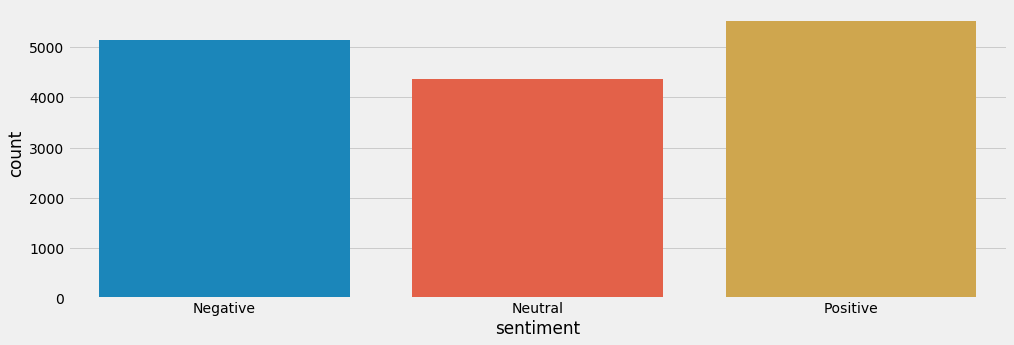

In [142]:
sent_count = pd.DataFrame.from_dict(Counter(sentimental_score_df['val']), orient = 'index').reset_index()
sent_count.columns = ['sentiment', 'count']

sns.barplot(y="count", x='sentiment', data=sent_count)

In [86]:
filepath = r"C:\Users\ROSHAN\Documents\GitHub\extracting-tweets-forecasting-the-upcoming-elections-in-the-us\NRC Emotion Lexicon.txt"
emolex_df = pd.read_csv(filepath,  names=["word", "emotion", "association"], skiprows=45, sep='\t')
emolex_df.head(12)
len(emolex_df)

86343

In [84]:
emotions={'positive':0, 'negative':0, 'surprise':0,'sadness':0,
          'anger':0,'joy':0,'negative':0,'trust':0,'fear':0,'anticipation':0,'disgust':0}

In [87]:
word_emotion=dict()
for i in range(0,86343):
    emotion=emolex_df['emotion'][i]
    word=emolex_df['word'][i]
    association=emolex_df['association'][i]
    
    if word not in word_emotion:
        word_emotion[word]=dict()
    word_emotion[word][emotion]=association
    

In [88]:
word_emotion

{'abandonment': {'joy': 0.0,
  'negative': 1.0,
  'positive': 0.0,
  'sadness': 1.0,
  'surprise': 1.0,
  'trust': 0.0},
 'abate': {'anger': 0.0,
  'anticipation': 0.0,
  'disgust': 0.0,
  'fear': 0.0,
  'joy': 0.0,
  'negative': 0.0,
  'positive': 0.0,
  'sadness': 0.0,
  'surprise': 0.0,
  'trust': 0.0},
 'abatement': {'anger': 0.0,
  'anticipation': 0.0,
  'disgust': 0.0,
  'fear': 0.0,
  'joy': 0.0,
  'negative': 0.0,
  'positive': 0.0,
  'sadness': 0.0,
  'surprise': 0.0,
  'trust': 0.0},
 'abba': {'anger': 0.0,
  'anticipation': 0.0,
  'disgust': 0.0,
  'fear': 0.0,
  'joy': 0.0,
  'negative': 0.0,
  'positive': 1.0,
  'sadness': 0.0,
  'surprise': 0.0,
  'trust': 0.0},
 'abbot': {'anger': 0.0,
  'anticipation': 0.0,
  'disgust': 0.0,
  'fear': 0.0,
  'joy': 0.0,
  'negative': 0.0,
  'positive': 0.0,
  'sadness': 0.0,
  'surprise': 0.0,
  'trust': 1.0},
 'abbreviate': {'anger': 0.0,
  'anticipation': 0.0,
  'disgust': 0.0,
  'fear': 0.0,
  'joy': 0.0,
  'negative': 0.0,
  'positi

In [138]:
for i in range(0,15046):
    text=df['Tweet'][i]
    for j in text.split():
        if j in word_emotion:
            for k in word_emotion[j]:
                emotions[k]+=word_emotion[j][k]

@JoeBiden VP Biden I wish you wouldn't debate Trump unless he: Debate #1 Trump shows taxes
Debate #2 Tells Putin stop killing our soldiers
Debate #3 Put sanctions on Putin for 2016 election hacks
&amp; I wish you'd publicly challenge him with this. #Biden/Rice 2020
#GeorgeWill , it’s so sad you wake up everyday forgetting that YOU George Will, are an #Elitist , just like all the Swampers we so badly need to disinfect. You’re a new breed of “SenileElites.”  Same as the man you plan to vote for #Biden https://t.co/zhhB2mxUtM
Question:
If @JoeBiden doesn’t pick a woman of color, would the black community hold it against him?
#Resist #Biden #BidenRepublicans
Right? 🤣🤣🤣 #Biden formally implicated in #Ukraine scandal @ChanelRion reported this afternoon 
 #Burisma https://t.co/B13j0IR6er
These idiots let Trump do anything he wants. When Biden gets elected, I don't want to hear a word. 

I hope #Biden and #Barack come through like: https://t.co/2ZIbeGqQc8
How could #Biden be +4 in #Ohio and +3

Chief Mouhamadou: "they want us to think that #Biden will save us from secret police."
Announced last week, not one word. Complete MSM blackout.  #Biden under investigation in the #Ukraine. https://t.co/rcjJxxQ5ST
Would you rather see #KamalaHarris as #Biden's VP or his AG(replacing #Barr)? https://t.co/ENsUWovQe1
@dbongino We have to make up for all the dead people and cats and multi-votes the #Democrats bring.
Let's not forget the inevitable tractor trailer full of ballots they suddenly find when they are losing - miraculously all for #Biden
@sunsetsue2 @realDonaldTrump Maybe the same ones that had the #Democrats nominate #Hillary &amp; then #Biden instead of a decent honest person,  @BernieSanders
#If2020WereAnAlcoholicDrink it would be a Molotov Cocktail. In a dumpster. In a rat-infested dumpster. It's fine, it's all fine.
#Biden Inauguration in 182 Days!
#Biden2020ToSaveAmerica https://t.co/sualozKZgJ
8 years of #Obama bowing to foreign leaders &amp; now #Biden is kneeling before 

I’m curious, Biden- how much of Your white wealth are you planning to return to the people of lower incomes? #Biden
Vote this #StableGenius out and vote #Biden https://t.co/guU7owwgIA
#dementiaJoe #Biden can’t even get one full coherent sentence out of his mouth. #Trump2020 https://t.co/EL2noQi3Bi
Too bad. Because that’s exactly what  @PressSec is. #KayleighLies #PressBriefing #trump #LiarInChief #fraud #failure #TRE45ON #DonTheCon #CountryOverParty #vote #Biden #Election2020

WH transcript confirms reporter did not call Kayleigh an obscenity  
https://t.co/fu8LAVcJ0U
We were warned. 

#VoteBlueToEndThisNightmare 
#Vote #Biden https://t.co/8sqk1tniAi
@nypost He is too weak and scared, the man is not fit to be President! #Biden
@realDonaldTrump @BarackObama @JoeBiden was part of a successful administration. No matter what u do, history will show u were nothing but an abject failure, a criminal who hoodwinked ur constituency. #Biden will lead us back to a positive America once we escort 

#uspoli djt urges #Putin #Biden Assassin b4 #Election2020 by @Patbagley https://t.co/fX1j3Fl53m   #uspolitics #bunkerboy #trumpisnotwell 🇺🇸🇺🇸🇺🇸🇺🇸 #maga #kag
Shoes of the nurses that have died on the front lines.. #COVID19 #Biden #pandemic #BetterDays https://t.co/ApJvLD8ioa https://t.co/5Qq6OqKu3v
Do not let the violent, fascist, deeply misogynistic #GOP cult of #YohoTheYahoo establish dictatorship in the #USA. #Biden will unite Democrats to help left-wing politicians like AOC simply REPLACE the moribund mysogynist #AntiChoice #PartyOfTheForeigner #GOPutin Republican Party https://t.co/BnrQS10kKn
@Friends9157 You vote for #Biden, me.... I like #winningwednesday  
#Trump2020LandslideVictory 🏁🇺🇸🤩
#WheresHunter 😳 https://t.co/WWnArB9gL6
I’m going to vote for #Biden using mail in votes and it’s gonna piss trump off so much ❤️💚💚
#Biden Too Senile
He did this, and began wearing a mask, hours after he was shown polling 15+ points behind Biden #coronavirus #TrumpMeltdown #Biden https://t.co/E5

#Biden2020 #Biden #GoJoe #ronjohnson https://t.co/Zjxwp30LR2
Count #Trumpula is not my #FavoritePresident (#CountTrumpula #TheCurseOfTrumpula #NotMyFavoritePresident #EndTheNightmare #AmericaStrongerWithBiden #DumpTrump #DumpTrump2020 #DefeatTrump #TrumpOut2020 #Biden2020 #Biden #JoeBiden @JoeBiden). https://t.co/CfCEgZY5kE
@RealJamesWoods @2precious1 JOE #BIDEN GO A NEW CAMPAIGN AD  FROM #PELOSI https://t.co/g4F3I6PMND
“The time is always right to do what is right” - Martin Luther King Jr.

#BLM #politics #change #CivilRights #rights #america #biden #trump #government
Watching @maddow-#GOP is un pockets of #Putin-they will not support this from #Biden-they r all dirty #corrupt #traitors
@WashTimes @WashTimesOpEd Nah... We just didn't want to vote for CORRUPT Hillary.

Same way we won't be voting for CORRUPT, owned by China, #Biden.
MSBNC’s #JoyReid praised for #Biden and #Hillary interviews on first episode of new primetime show #TheReidOut

“We were thinking of you for vice president

Victor Shokin~ #Biden
Attempted #Murder #federal #JudgeEstherSalas connected #DeutscheBank #Epstein &amp; #Russia - #Trump putting #puppets in #PENTAGON - preparing for #militarycoup after he loses election to #Biden - all paths lead to #Putin - #25thAmendmentNow before it's too late!
Same #GOP Back Stabbers that were Forced OUT of Party in 2016 are Chiming In Again. Only #CNN #MSNBC have Trashed USA Beyond Saving Now. #msnbc #foxnews #nytimes #nyt #wsj #biden #politico #huffpost #drudge #bbc #gop #npr #dailykos #thehill #wapo #nbc #cbs #ap #slate #aarp #nyc https://t.co/oJM9O3lBbO
If you vote for #Biden you don’t care about your future or your family. Period. You’re fine with having less money 💰. Pure and simple. https://t.co/ozHiMw36TE
@SymoneDSanders @K_JeanPierre this goes without saying, but under NO circumstances should you bow to trump's idiocy by administering any cognitive tests to #Biden. This is trump's tired birther "ish" in a slightly different package. Let that racist spe

OMG!  Don't ppl see this is future if #Biden wins?

Test + for #COVID &amp; govt owns you.  They decide when &amp; if leave home!

#Trump2020 

Kentucky couple fit with ankle monitors, placed on house arrest, for refusing to sign quarantine documents: reports

https://t.co/gLPamHd8wR
There’s no way @JoeBiden controls his own Twitter. The sentences make WAY too much sense. #2020Election #Biden #Trump #Democrats #Republicans
@HouseGOP The #GreatAmericanComeback is coming on January 20th, 2021 when President elect Joe #Biden is sworn in. 😷
@realDonaldTrump What we WON’T do is use euphemisms like “embers” to deacribe thousands of American deaths. #embers #COVIDー19 #ChrisWallace #DonaldTrump #TrumpThreatensAmerica #Biden
@Ihavenousefora1 @Poetic_brand @1nicholedejesus @HowieHawkins @AngelaNWalker @wirelesshogan @LaRivaPeltier @jkishore Lol.
#Biden = NO #MedicareForAll 
#Hawkins = #MedicareForAll 
#Biden = #Fracking
#Hawkins = NO #Fracking
#Biden = cut military budget 10%
#Hawkins = cut mili

 https://t.co/JqFQ4unVed
November can't come soon enough. I can't wait until Americans get to say "You're Fired!"
#TrumpFailsAmerica #TrumpIsUnwell #TrumpIsATraitor #DonaldTrump #Election2020 #Biden #Biden2020 #COVIDー19 #coronavirus 
https://t.co/AvpfcU7My9
@realDonaldTrump Hey moron...all of this darkness, despair, dysfunction, disease, death you're showing here happened on YOUR watch. Great ad for #Biden.... #Trump #Election2020
@IngrahamAngle A vote for Trump will give this propagandist a stage  to continue her deceit. 
#Biden
#McGrath
#Harrison
#Gideon
#Kelly
#Hickenlioper
#Greenfield
#BlueAllTheWay
@NewMexicoGOP @katrina021914 @AZGOP #Biden's functional endorsement of @AOC's #GreenNewDeal is just plain cuckoo for Cocoa Puffs from nuts to soup.

Not only is it economically 🦇💩crazy, it shows they don't even have a rudimentary grasp of basic physics.

They are either idiots, villains or fools. Maybe all 3...
@realDonaldTrump Mary is right, you are a pathological liar. Joe Biden has n

If you believe Trump is racist...and Biden isn't....it's because you are racist.

#Trump
#Biden
#election2020
I'm buying one gun every week until election day. Just in case #Biden and his band of misfits win. If @realDonaldTrump wins , which I pray for , I sell what I don't want. If Biden and his band of anarchists win , I want to be prepared
Don't get complacent. We must fight like Biden is losing. #Biden #VoteBlueToSaveAmerica
Trump's campaign reshuffle shows he's figured out he's losing https://t.co/7lhPOVYmMj
@LindseyGrahamSC The #Biden administration took down the U.S. to new historic lows!!
@iammix24 @realDonaldTrump #Biden doesn't need to debate #lysonDon. He can just ran out the clock and the #OrangeImbecile will lose badly in November.
So great to see a liar called out. And on Fox fake news no less. #biden is for positive change in the police force, NOT defunding. Get your facts straight #POTUS! #VoteTrumpOut2020 #VoteBidenToSaveAmerica https://t.co/hUYD8sH0oK
@JpeBiden #Biden

#VoteTrumpOut
@LjTass Nope. In November I expect it will be right side up. #BidenForPresident #Biden2020 #biden #Resist
Make this go viral. Biden ain’t the person y’all think he is. #trump2020 #biden #america #2020election https://t.co/UbVoHtoo7t
@kitagawa_kazuo It’s time that your party supports Gay marriage NOW! LGBTQ rights need to be in your anime to help the youth come out! Also realize there are many trans people being oppressed in Japan. #Biden will stop trade with you if you don’t #wakeup! #Biden2020
@4AnimalLife @beth_kania @ianbremmer @Lawrence @RepBrianHiggins If I was Canadian, Mexican, Guatemalan, English, French, German, Chinese,  or Japanese etc. I would urge my government to close the borders to Americans. Our President has failed in handling the virus, economy, immigration, rule of law. Would love to be out of here until #Biden
Former Iranian Hostage Slams #Biden for Abandoning Him in Tehran https://t.co/cdpCZ4GbRK - plus #obama
@lesleyabravanel @realDonaldTrump I get 

#biden  Yesterday  : I thought my twitter password was Ilovesniffingyoungkids  I just pretend i got hacked so no one thinks its my dementia again  🤣
#Trump and #Biden
Now Trump is blaming Biden for all problems in the US. He has forgotten one item: His casino crashed because Biden played there!
America’s Cops Back #Trump Instead Of #Biden 

National Association of Police Organizations endorses Trump, after backing Biden as VP in '08, '12 https://t.co/WfjRT3DzzX #FoxNews
Apparently not only in #Venezuela, but also in #Iran, there is a collaborationist opposition seeking a "negotiated" solution to their conflict
Furthermore, similar to our pseudo-opposition they wish #Biden to win because he would push a "diplomatic solution" with totalitarianism. https://t.co/3Rgf1cVwne
@Orion83D @Maltomash Absolutely, won’t mind a temporary Canadian take over till #Biden is our President, come get rid of this clown 🤡
@thedevient72 @Breaking911 That’s President Cheeto to you...and get used to it, becaus

See:https://t.co/uWdnCoOe5x
@TONYxTWO @realDonaldTrump America desperately needs a real, caring, capable leader. #DumpTrump2020 #dumptrump #Biden #biden2020
Black Lives Matter - Victoria Square ( Na oume )

#biden would be proud https://t.co/9fgp5prThB
#Marxist #AngelaDavis sees #Biden as the ideal #Candidate...
Celebrity #Marxist #AngelaDavis sees #Biden as easily 'pressured’ | FreePressers
https://t.co/1nJ9vUNF7z 
#JoeBiden #SnowFlake #Loser #Patsy #Tcot #Tgdn #Teaparty #Trump #Trump2020 #Kag #Kag2020 #MAGA #MAGA2020 #TrumpTrain #2020Election #Election2020 #Election
Opinion | The nation is in a downward spiral. Worse is still to come. https://t.co/g3iBbEBaBw  #VoteBlue2020 #Biden #JoeBiden2020 #BlueWave2020
Monday, when #Trump claimed #Biden was a radical &amp; reckless politician who opposes “our law enforcement heroes,” was the 1st working day after he commuted #RogerStone's sentence. Irony may be dead in Trump’s America, but polling isn’t. https://t.co/3sccwGtkev #MAGA? #YouFools!

Exactly was VP  for 8 years and in the Political arena for decades. Why wasn’t Health Care. Prison Reform and Immigration taken care of before Trump got elected? #Covid #Biden #Fauci #Trump  https://t.co/WbhIIoKwNr
@KellyannePolls @JennaEllisEsq #Democrats will destroy this if successful. Remember,  they hate #America. They emptied prisons so criminals can run free. Then let their own cities get looted and burned. Now they believe that if they #defund the #police we all will be safer.  #Biden is in on it.

#TRUMP2020
@realDonaldTrump @SaraCarterDC @TTuberville @DougJones Wow!! #Biden Will win big against Trump.
Thanks for the next #Biden commercial, asshat! 😂

#TrumpIsUnwell #RoseGarden #PressConference https://t.co/HtQ9QFLptU
The world is laughing at president Trump.

#indiegame #iosgame #indiedev #indiedeveloper #biden #joebiden #democrat #pixelart #pixelartgame #funnygame #caricature #caricatures #politicalgame #politicalgames #gamer #mobilegaming #mobilegamer #mobilegamereviews htt

Not seeing that #Biden is a white supremacist:what imbecility https://t.co/5NNGfg0LBO
When #JoeBiden is #potus the full truth will be told at the #TrumpCrimesCommission. No member of the #TrumpCrimeFamily #TrumpCrimeSyndicate will be given a pass. AND #Biden’s AG will demand a full investigation into the sexual abuse @OhioState wrestling &amp; YOUR roll in coverup. https://t.co/0aZxUklNyc
Yep, excellent point about #Biden https://t.co/gOme5Tbfbf
A ringing endorsement right there 😂 #trump #Biden https://t.co/aq2naO40Xr
@noahluvsanimals Dude, I can’t follow you. 
You support #Biden and he and his son took $1.5 billion dollars from Chinese investment firms. 
That is a fact. 
Please do some reading.
@Wyn1745 @1216tor Anyone notice when #Biden speaks.. there’s always a lot of BIRDS AND FOWEL about?
In that sense, #Biden was right to #quote #Plato: "The penalty people face for not being involved in politics is being governed by people worse than themselves." #politics #Election2020 https://t

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [91]:
emotions

{'positive': 5752.0,
 'negative': 5936.0,
 'surprise': 1491.0,
 'sadness': 2759.0,
 'anger': 3044.0,
 'joy': 1994.0,
 'trust': 3538.0,
 'fear': 3265.0,
 'anticipation': 2296.0,
 'disgust': 1944.0}

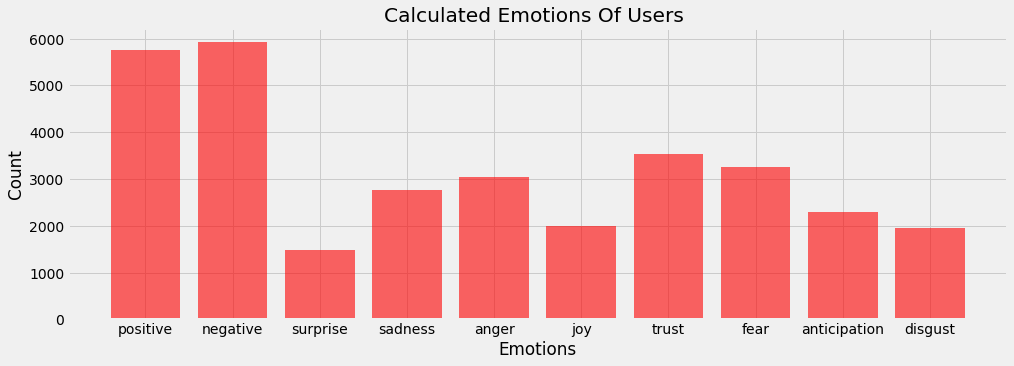

In [137]:
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = [15,5]
plt.bar(list(emotions.keys()),list(emotions.values()),color='red',alpha = 0.6)
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.title('Calculated Emotions Of Users ')
plt.show()

In [116]:
df.Location  = df.Location.fillna('USA')

In [117]:
f = [i for i in df['Location'] if type(i) != str]
f

[]

In [118]:
df.Location = df.Location.apply(lambda x: x.replace('United States','USA'))

In [123]:
df.Location.value_counts()

USA                               5487
First star to the right            174
Florida, USA                       158
Washington, DC                     157
Earth                              136
                                  ... 
The Republic of #Texas               1
Roswell, Georgia                     1
Farmhouse                            1
N e w  M e x i c o - T e x a s       1
Left corner underneath the bed       1
Name: Location, Length: 3195, dtype: int64

In [135]:
locations = []
locations_1 = []

locations = [i.split(',')[-1] for i in df['Location']]
locations_1 =  [i.split(',')[0] for i in df['Location']]
df['Processed_Location'] = locations_1
df

Date             Tweet_id  Verified  \
0     2020-07-21 23:59:43  1285726179907993601     False   
1     2020-07-21 23:59:27  1285726110513344520     False   
2     2020-07-21 23:59:24  1285726099239055361     False   
3     2020-07-21 23:58:47  1285725945849151490     False   
4     2020-07-21 23:58:02  1285725754961965056     False   
...                   ...                  ...       ...   
15041 2020-07-13 10:57:58  1282630342038499329     False   
15042 2020-07-13 10:56:26  1282629958205145091     False   
15043 2020-07-13 10:53:50  1282629302199164928     False   
15044 2020-07-13 10:53:46  1282629284524433409     False   
15045 2020-07-13 10:45:12  1282627129172271104     False   

                                                   Tweet             User  \
0      @JoeBiden VP Biden I wish you wouldn't debate ...    BballmomEjZay   
1      #GeorgeWill , it’s so sad you wake up everyday...        TalbotMac   
2      Question:\nIf @JoeBiden doesn’t pick a woman o...   bk_middleclass   
3      Right? 🤣🤣🤣 #Biden formally implicated in #Ukra...     MMorganBlair   
4      These idiots let Trump do anything he wants. W...      realfacade1   
...                                                  ...              ...   
15041  Other than going big by eulogizing #StromThurm...  robertson_alton   
15042  Don't want to leave out the left! Show your su...    GraphicMedia4   
15043  Some chatter about #Biden maybe activating res...     copiousjawnt   
15044  Fake #Polls? Why #Biden's 'Nationwide Lead' Ov...        blinova14   
15045  #Joe #Biden #Trump police should not be armed ...      try4freedom   

                           Location               Source  Likes  Followers  \
0                               USA  Twitter for Android      0         54   
1                   East Aurora, NY   Twitter for iPhone      0        882   
2                     Nashville, TN   Twitter for iPhone      0       1294   
3                               USA   Twitter for iPhone      1       2476   
4                        Purgatory   Twitter for Android      0       2764   
...                             ...                  ...    ...        ...   
15041  Fort Worth, or thereabouts.       Twitter Web App      0       1004   
15042                           USA      Twitter Web App      0          1   
15043             Lehigh Valley, PA  Twitter for Android      0         84   
15044                           USA      Twitter Web App      4        836   
15045                 Brookline, MA       Smart Post App      1        125   

       Following  Retweets                                    Processed_Tweet  \
0            192         0  [biden, wish, debat, trump, unless, debat, tru...   
1           1554         0  [georgewil, sad, wake, everyday, forget, georg...   
2           1213         0  [question, doesnt, pick, woman, color, would, ...   
3           3334         1  [right, biden, formal, implic, ukrain, scandal...   
4           3799         0  [idiot, let, trump, anyth, want, biden, get, e...   
...          ...       ...                                                ...   
15041       4999         0  [big, eulog, stromthurmond, look, right, look,...   
15042          0         0  [want, leav, leav, show, support, elect, heart...   
15043        210         0  [chatter, biden, mayb, activ, resourc, fight, ...   
15044        432         0  [fake, poll, biden, nationwid, lead, trump, sa...   
15045        612         0             [joe, biden, trump, polic, arm, teeth]   

      Processed_Location  
0                    USA  
1            East Aurora  
2              Nashville  
3                    USA  
4             Purgatory   
...                  ...  
15041         Fort Worth  
15042                USA  
15043      Lehigh Valley  
15044                USA  
15045          Brookline  

[15046 rows x 13 columns]

In [147]:
df1 = df

In [148]:
df1['sentiment'] = sentimental_score_df['val']

In [150]:
df1.head()

Date             Tweet_id  Verified  \
0 2020-07-21 23:59:43  1285726179907993601     False   
1 2020-07-21 23:59:27  1285726110513344520     False   
2 2020-07-21 23:59:24  1285726099239055361     False   
3 2020-07-21 23:58:47  1285725945849151490     False   
4 2020-07-21 23:58:02  1285725754961965056     False   

                                               Tweet            User  \
0  @JoeBiden VP Biden I wish you wouldn't debate ...   BballmomEjZay   
1  #GeorgeWill , it’s so sad you wake up everyday...       TalbotMac   
2  Question:\nIf @JoeBiden doesn’t pick a woman o...  bk_middleclass   
3  Right? 🤣🤣🤣 #Biden formally implicated in #Ukra...    MMorganBlair   
4  These idiots let Trump do anything he wants. W...     realfacade1   

          Location               Source  Likes  Followers  Following  \
0              USA  Twitter for Android      0         54        192   
1  East Aurora, NY   Twitter for iPhone      0        882       1554   
2    Nashville, TN   Twitter for iPhone      0       1294       1213   
3              USA   Twitter for iPhone      1       2476       3334   
4       Purgatory   Twitter for Android      0       2764       3799   

   Retweets                                    Processed_Tweet  \
0         0  [biden, wish, debat, trump, unless, debat, tru...   
1         0  [georgewil, sad, wake, everyday, forget, georg...   
2         0  [question, doesnt, pick, woman, color, would, ...   
3         1  [right, biden, formal, implic, ukrain, scandal...   
4         0  [idiot, let, trump, anyth, want, biden, get, e...   

  Processed_Location sentiment  
0                USA  Negative  
1        East Aurora  Negative  
2          Nashville   Neutral  
3                USA  Negative  
4         Purgatory   Positive

In [ ]:
df1.to_csv('Location.csv',index = False)

In [162]:
df1['day'] = df.Date.dt.day
df1.head()

Date             Tweet_id  Verified  \
0 2020-07-21 23:59:43  1285726179907993601     False   
1 2020-07-21 23:59:27  1285726110513344520     False   
2 2020-07-21 23:59:24  1285726099239055361     False   
3 2020-07-21 23:58:47  1285725945849151490     False   
4 2020-07-21 23:58:02  1285725754961965056     False   

                                               Tweet            User  \
0  @JoeBiden VP Biden I wish you wouldn't debate ...   BballmomEjZay   
1  #GeorgeWill , it’s so sad you wake up everyday...       TalbotMac   
2  Question:\nIf @JoeBiden doesn’t pick a woman o...  bk_middleclass   
3  Right? 🤣🤣🤣 #Biden formally implicated in #Ukra...    MMorganBlair   
4  These idiots let Trump do anything he wants. W...     realfacade1   

          Location               Source  Likes  Followers  Following  \
0              USA  Twitter for Android      0         54        192   
1  East Aurora, NY   Twitter for iPhone      0        882       1554   
2    Nashville, TN   Twitter for iPhone      0       1294       1213   
3              USA   Twitter for iPhone      1       2476       3334   
4       Purgatory   Twitter for Android      0       2764       3799   

   Retweets                                    Processed_Tweet  \
0         0  [biden, wish, debat, trump, unless, debat, tru...   
1         0  [georgewil, sad, wake, everyday, forget, georg...   
2         0  [question, doesnt, pick, woman, color, would, ...   
3         1  [right, biden, formal, implic, ukrain, scandal...   
4         0  [idiot, let, trump, anyth, want, biden, get, e...   

  Processed_Location sentiment  day  
0                USA  Negative   21  
1        East Aurora  Negative   21  
2          Nashville   Neutral   21  
3                USA  Negative   21  
4         Purgatory   Positive   21

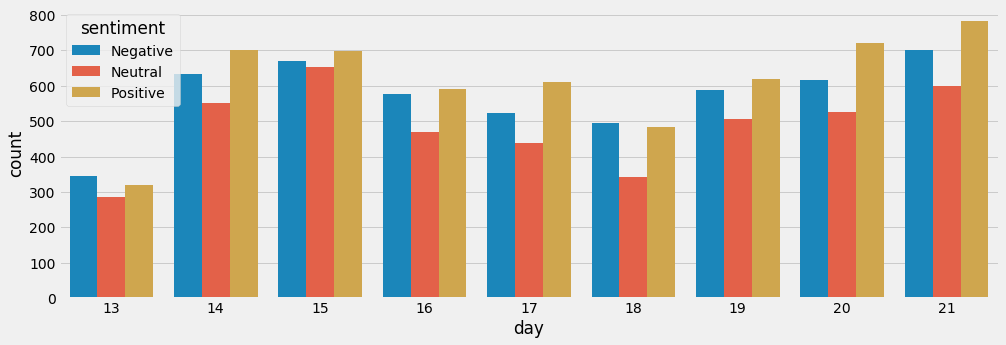

In [165]:
sns.countplot(df['day'],hue = df['sentiment'])

In [166]:
df1.to_excel("output.xlsx") 

C:\Users\ROSHAN\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:931: UserWarning: Ignoring URL 'https://t.co/9lR4kHJ1pl%20' with link or location/anchor > 255 characters since it exceeds Excel's limit for URLS
  force_unicode(url))
C:\Users\ROSHAN\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:931: UserWarning: Ignoring URL 'https://t.co/1eCUiOYKuW%20After%20Trump%20attacked%20the%20CDC%20and%20public%20health%20experts%20who%20should%20be%20guiding%20our%20response%20to%20COVID-19,%20Joe%20released%20a%20statement%20that%20Trump%20%22is%20undercutting%20our%20response%20to%20this%20unprecedented%20crisis%20and%20it’s%20costing%20Americans%20jobs%20and%20their%20lives.”%20' with link or location/anchor > 255 characters since it exceeds Excel's limit for URLS
  force_unicode(url))
C:\Users\ROSHAN\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:931: UserWarning: Ignoring URL 'https://t.co/ilxWwPhyue%20%20' with link or location/anchor > 255 characters since it exceeds Excel'

## Predictions

In [170]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder 

In [171]:
le = LabelEncoder() 
  
df1['sentiment_1']= le.fit_transform(df1['sentiment']) 

In [172]:
df1

Date             Tweet_id  Verified  \
0     2020-07-21 23:59:43  1285726179907993601     False   
1     2020-07-21 23:59:27  1285726110513344520     False   
2     2020-07-21 23:59:24  1285726099239055361     False   
3     2020-07-21 23:58:47  1285725945849151490     False   
4     2020-07-21 23:58:02  1285725754961965056     False   
...                   ...                  ...       ...   
15041 2020-07-13 10:57:58  1282630342038499329     False   
15042 2020-07-13 10:56:26  1282629958205145091     False   
15043 2020-07-13 10:53:50  1282629302199164928     False   
15044 2020-07-13 10:53:46  1282629284524433409     False   
15045 2020-07-13 10:45:12  1282627129172271104     False   

                                                   Tweet             User  \
0      @JoeBiden VP Biden I wish you wouldn't debate ...    BballmomEjZay   
1      #GeorgeWill , it’s so sad you wake up everyday...        TalbotMac   
2      Question:\nIf @JoeBiden doesn’t pick a woman o...   bk_middleclass   
3      Right? 🤣🤣🤣 #Biden formally implicated in #Ukra...     MMorganBlair   
4      These idiots let Trump do anything he wants. W...      realfacade1   
...                                                  ...              ...   
15041  Other than going big by eulogizing #StromThurm...  robertson_alton   
15042  Don't want to leave out the left! Show your su...    GraphicMedia4   
15043  Some chatter about #Biden maybe activating res...     copiousjawnt   
15044  Fake #Polls? Why #Biden's 'Nationwide Lead' Ov...        blinova14   
15045  #Joe #Biden #Trump police should not be armed ...      try4freedom   

                           Location               Source  Likes  Followers  \
0                               USA  Twitter for Android      0         54   
1                   East Aurora, NY   Twitter for iPhone      0        882   
2                     Nashville, TN   Twitter for iPhone      0       1294   
3                               USA   Twitter for iPhone      1       2476   
4                        Purgatory   Twitter for Android      0       2764   
...                             ...                  ...    ...        ...   
15041  Fort Worth, or thereabouts.       Twitter Web App      0       1004   
15042                           USA      Twitter Web App      0          1   
15043             Lehigh Valley, PA  Twitter for Android      0         84   
15044                           USA      Twitter Web App      4        836   
15045                 Brookline, MA       Smart Post App      1        125   

       Following  Retweets                                    Processed_Tweet  \
0            192         0  [biden, wish, debat, trump, unless, debat, tru...   
1           1554         0  [georgewil, sad, wake, everyday, forget, georg...   
2           1213         0  [question, doesnt, pick, woman, color, would, ...   
3           3334         1  [right, biden, formal, implic, ukrain, scandal...   
4           3799         0  [idiot, let, trump, anyth, want, biden, get, e...   
...          ...       ...                                                ...   
15041       4999         0  [big, eulog, stromthurmond, look, right, look,...   
15042          0         0  [want, leav, leav, show, support, elect, heart...   
15043        210         0  [chatter, biden, mayb, activ, resourc, fight, ...   
15044        432         0  [fake, poll, biden, nationwid, lead, trump, sa...   
15045        612         0             [joe, biden, trump, polic, arm, teeth]   

      Processed_Location sentiment  day  sentiment_1  
0                    USA  Negative   21            0  
1            East Aurora  Negative   21            0  
2              Nashville   Neutral   21            1  
3                    USA  Negative   21            0  
4             Purgatory   Positive   21            2  
...                  ...       ...  ...          ...  
15041         Fort Worth  Negative   13            0  
15042                USA 

In [173]:
cv = CountVectorizer(max_features = 1500)
X = cv.fit_transform(all_words).toarray()
y = df1['sentiment_1']

In [183]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [184]:
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

In [185]:
y_pred_DT = classifier.predict(X_test)

In [186]:
cm_DT = confusion_matrix(y_test, y_pred_DT)

In [187]:
cm_DT

array([[1091,  102,  312],
       [ 109, 1153,   50],
       [ 251,   72, 1374]], dtype=int64)

In [188]:
from sklearn.metrics import accuracy_score

In [189]:
accuracy_score(y_test, y_pred_DT)

0.8015064244572442

#### Hyperparameter tuning